- Importando bibliotecas e funções necessárias:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from scipy.special import hyp2f1
from scipy.integrate import solve_ivp, quad, quad_vec
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as cnt
from sympy import symbols, Eq, solve, nsimplify

---------

- Todas as variáveis aqui definidas são as variáveis adimensionais. O índice $a$ foi omitido por simplicidade.

----------

- Definindo a cosmologia de Einstein-de Sitter: $\Omega_{\textrm{m}0} = 1$

$a = \left(\dfrac{3}{2}\sqrt{\Omega_{\textrm{m}0}} t_{\textrm{a}}\right)^{2/3}$

$H_{\textrm{a}}(t_{\textrm{a}}) = \sqrt{\dfrac{\Omega_{\textrm{m}0}}{a^3(t_{\textrm{a}})}}$

$\rho_a(t_{\textrm{a}}) = \dfrac{\rho_{m,0}}{a^3(t_{\textrm{a}})}$

$t_{\textrm{a}}(a) = \dfrac{2a^{3/2}}{3\Omega_{\textrm{m}0}}$

In [2]:
# Universo EdS:

omega_EdS = 1 # parâmetro de densidade

def a_EdS(t): # em função do tempo adimensional
    return ((3/2)*np.sqrt(omega_EdS)*t)**(2/3)

def H_EdS(t): # adimensional: H/H_0
    return np.sqrt(omega_EdS/a_EdS(t)**3)

def rho_EdS(t): # adimensional: rho/rho_0
    return 1/a_EdS(t)**3

def t_EdS(a): # tempo adimensional em função do fator de escala
    return 2*(a**(3/2))/(3*np.sqrt(omega_EdS))

def a_z(z): # em função do redshift (vale também para LCDM)
    return 1/(1 + z)

# Condições iniciais:
a_EdS_i = 1/101 # z = 100
t_i_EdS = t_EdS(a_EdS_i) # z = 100
t_0_EdS = t_EdS(1) # z = 0
H_EdS_i = H_EdS(t_i_EdS)
t_eixo_EdS = np.linspace(t_i_EdS, t_0_EdS, 10**4)

- Definindo a cosmologia $\Lambda\textrm{CDM}$: $\Omega_{\textrm{m}0} = 0.3$, $\Omega_{\Lambda 0} = 1 - \Omega_{\textrm{m}0}$

$a(t_{\textrm{a}}) = \left(\dfrac{\Omega_{\textrm{m}0}}{\Omega_{\Lambda 0}}\right)^{1/3}\sinh^{2/3}{\left(\dfrac{3\sqrt{\Omega_{\Lambda 0}} t_{\textrm{a}}}{2}\right)}$

$H_a(t_{\textrm{a}}) = \sqrt{\dfrac{\Omega_{\textrm{m}0}}{a^3(t_{\textrm{a}})} + \Omega_{\Lambda 0}}$

$t_{\textrm{a}}(a) = \dfrac{2}{3\sqrt{\Omega_{\Lambda 0}}} \arcsin{\left[\left(\dfrac{\Omega_{\Lambda 0}}{\Omega_{\textrm{m}0}}\right)^{1/2} a^{3/2}\right]}$

$\rho_a(t_{\textrm{a}}) = \dfrac{\rho_{m,0}}{a^3(t_{\textrm{a}})}$

In [3]:
# Universo LCDM:

omega_m_LCDM = 0.3 # parâmetro de densidade de matéria
omega_L_LCDM = 1 - omega_m_LCDM # parâmetro de densidade da constante cosmológica

def a_LCDM(t): # em função do tempo adimensional
    return ((omega_m_LCDM/omega_L_LCDM)**(1/3))*((np.sinh((3*t/2)*np.sqrt(omega_L_LCDM)))**(2/3))

def H_LCDM(t): # adimensional: H/H_0
    return np.sqrt(omega_m_LCDM/a_LCDM(t)**3 + omega_L_LCDM)

def rho_LCDM(t): # adimensional: rho/rho_0
    return 1/a_LCDM(t)**3

def t_LCDM(a): # tempo adimensional em função do fator de escala:
    return (2/(3*np.sqrt(omega_L_LCDM)))*np.arcsinh(((omega_L_LCDM/omega_m_LCDM)**(1/2))*(a**(3/2)))

# Condições iniciais:
a_LCDM_i =  1/101 # z = 100
t_i_LCDM = t_LCDM(a_LCDM_i) # z = 100
t_0_LCDM = t_LCDM(1) # z = 0
H_LCDM_i =  H_LCDM(t_i_LCDM) 
t_eixo_LCDM = np.linspace(t_i_LCDM, t_0_LCDM, 10**4)

- Retomando unidades de medida:

In [4]:
# Para os plots:
h = 0.68

# Constante de Hubble:
H0_s = 100*h/(3.086e19) # Converte H0 = 68 km/s/Mpc para s^-1 com 1 Mpc = 3.086e19 km

# Densidade atual:
rho_0_EdS = (3*omega_EdS*H0_s**2)/(8*np.pi*cnt.G) # kg/m^3
rho_0_LCDM = (3*omega_m_LCDM*H0_s**2)/(8*np.pi*cnt.G) # kg/m^3

# Para ficar em massas solares por Mpc:
def kmm3_para_MsunMpc3(densidade):
    return densidade*(3.086e22)**3/(1.989e30) # Converte kg para massas solares com Msun = 1.989e30 kg e m^3 para Mpc^3 com Mpc = 3.086e22

rho_0_EdS_2 = kmm3_para_MsunMpc3(rho_0_EdS)
rho_0_LCDM_2 = kmm3_para_MsunMpc3(rho_0_LCDM)

# Tempo para gigaanos:
def t_Gyrs(t):
    t_s = t / H0_s  # Converte tempo adimensional em segundos
    return t_s / (3.154e16) # Converte segundo para gigaanos com 1 Gyr = 3.154e16 s

# Calculando o "hoje" para cada cosmologia:
print(f"O tempo equivalente a z = 0 é {round(t_Gyrs(t_0_EdS), 2)} gigaanos em EdS e {round(t_Gyrs(t_0_LCDM), 2)} gigaanos em LCDM.")

print(rho_0_EdS, rho_0_EdS_2)

O tempo equivalente a z = 0 é 9.59 gigaanos em EdS e 13.87 gigaanos em LCDM.
8.68363685764759e-27 128308265873.83621


--------

- Soluções numéricas e primeiro gráfico:

In [5]:
# Definindo as equações de Friedmann para serem resolvidas:

def FriedmannEdS(t, a): # equação para a' em EdS
    return a*np.sqrt(omega_EdS/a**3)

def FriedmannLCDM(t, a): # equação para a' em LCDM
    return a*np.sqrt(omega_m_LCDM/a**3 + omega_L_LCDM)

# Resolvendo:
a_numerico_EdS_1 = solve_ivp(FriedmannEdS, [t_eixo_EdS[0], t_eixo_EdS[-1]], [a_EdS_i], t_eval = t_eixo_EdS, dense_output = True)
a_numerico_EdS_1 = a_numerico_EdS_1.y[0]
a_numerico_LCDM_1 = solve_ivp(FriedmannLCDM, [t_eixo_LCDM[0], t_eixo_LCDM[-1]], [a_LCDM_i], t_eval = t_eixo_LCDM, dense_output = True)
a_numerico_LCDM_1 = a_numerico_LCDM_1.y[0]

# Parâmetro de Hubble em função do resultado numérico:
H_EdS_numerico_1 = np.sqrt(omega_EdS/a_numerico_EdS_1**3)
H_LCDM_numerico_1 = np.sqrt(omega_m_LCDM/a_numerico_LCDM_1**3 + omega_L_LCDM)

# Densidade em função do resultado numérico:
rho_numerico_EdS = 1/a_numerico_EdS_1**3
rho_numerico_LCDM = 1/a_numerico_LCDM_1**3

In [6]:
# Definindo legendas separadas para cada cosmologia, que serão utilizadas em vários plots:

EdS_legenda = [
    Line2D([0], [0], color = 'teal', linestyle = '-', label = 'Solução analítica'),
    Line2D([0], [0], color = 'navy', linestyle = 'dotted', label = 'Solução numérica')]
LCDM_legenda = [
    Line2D([0], [0], color = 'indianred', linestyle = '-', label = 'Solução analítica'),
    Line2D([0], [0], color = 'darkred', linestyle = 'dotted', label = 'Solução numérica')]

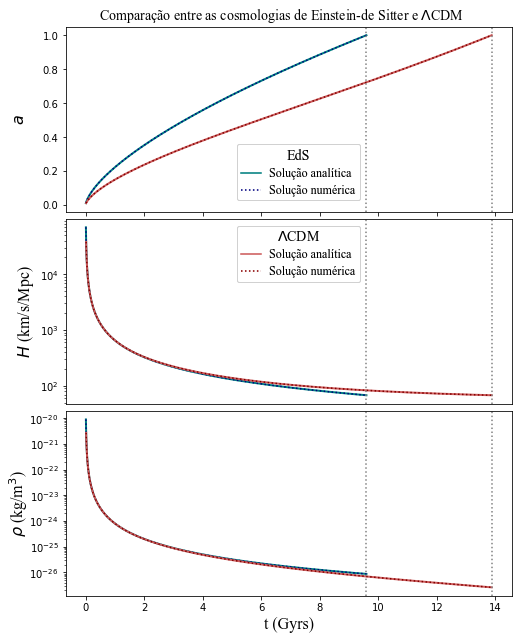

In [7]:
# Gráficos:

font_figF = {'family': 'Times New Roman', 'size': 14} # Fonte das legendas
figF, (plotF1, plotF2, plotF3, legend_subplot) = plt.subplots(nrows=4, ncols=1, figsize=(8, 14)) # Criando subplots

# Legendas em bloco:
Legenda_EdS_plotF1 = plotF1.legend(handles = EdS_legenda, bbox_to_anchor = (0.67, 0.39)) # Legendas no segundo subplot posicionadas manualmente
Legenda_EdS_plotF1.set_title("EdS", prop = font_figF) # Nomeando o primeiro bloco e definindo a fonte
for text in Legenda_EdS_plotF1.get_texts():
    text.set_fontfamily('Times New Roman')
    text.set_fontsize(12)
Legenda_LCDM_plotF2 = plotF2.legend(handles = LCDM_legenda, bbox_to_anchor = (0.67, 0.99))
Legenda_LCDM_plotF2.set_title("$\Lambda$CDM", prop = font_figF)  
for text in Legenda_LCDM_plotF2.get_texts():
    text.set_fontfamily('Times New Roman')
    text.set_fontsize(12)

figF.suptitle('Comparação entre as cosmologias de Einstein-de Sitter e $\Lambda$CDM',  fontsize = 14, family = 'Times New Roman', y = 0.9) # Colocando o título na posição adequada
plotF1.plot(t_Gyrs(t_eixo_EdS), a_EdS(t_eixo_EdS), color = 'teal', linestyle = '-', linewidth = 2) # Plota a solução analítica EdS
plotF1.plot(t_Gyrs(t_eixo_EdS), a_numerico_EdS_1, color = 'navy', linestyle = 'dotted') # Plota a solução numérica EdS
plotF1.plot(t_Gyrs(t_eixo_LCDM), a_LCDM(t_eixo_LCDM), color = 'indianred', linestyle = '-', linewidth = 2) # Plota a solução numérica LCDM
plotF1.plot(t_Gyrs(t_eixo_LCDM), a_numerico_LCDM_1, color = 'maroon', linestyle = 'dotted')  # Plota a solução analítica LCDM
plotF1.set_ylabel('$a$', fontsize = 16, family = 'Times New Roman') # Nomeia o eixo y
plotF1.set_xlabel('') # Nomeia o eixo x
plotF1.axvline(t_Gyrs(t_0_EdS), color = 'gray', linestyle = 'dotted') # Linha do "hoje" em EdS
plotF1.axvline(t_Gyrs(t_0_LCDM), color = 'gray', linestyle = 'dotted') # Linha do "hoje" em LCDM
plotF1.add_artist(Legenda_EdS_plotF1)
plotF1.yaxis.set_label_coords(-0.084, 0.5) # Alinhando o eixo vertical com os dos outros subplots

plotF2.plot(t_Gyrs(t_eixo_EdS), 68*H_EdS(t_eixo_EdS), color = 'teal', linestyle = '-', linewidth = 2)
plotF2.plot(t_Gyrs(t_eixo_EdS), 68*H_EdS_numerico_1, color = 'navy', linestyle = 'dotted')
plotF2.plot(t_Gyrs(t_eixo_LCDM), 68*H_LCDM(t_eixo_LCDM), color = 'indianred', linestyle = '-', linewidth = 2)
plotF2.plot(t_Gyrs(t_eixo_LCDM), 68*H_LCDM_numerico_1, color = 'maroon', linestyle = 'dotted')
plotF2.set_ylabel('$H$ (km/s/Mpc)', fontsize = 16, family = 'Times New Roman')
plotF2.set_xlabel('')
plotF2.set_yscale('log')
plotF2.axvline(t_Gyrs(t_0_EdS), color = 'gray', linestyle = 'dotted')
plotF2.axvline(t_Gyrs(t_0_LCDM), color = 'gray', linestyle = 'dotted')
plotF2.tick_params(axis = 'x', which = 'both', bottom=False, top=False, labelbottom=False)
plotF2.add_artist(Legenda_LCDM_plotF2)

plotF3.plot(t_Gyrs(t_eixo_EdS), rho_0_EdS*rho_EdS(t_eixo_EdS), color = 'teal', linestyle = '-', linewidth = 2)
plotF3.plot(t_Gyrs(t_eixo_EdS), rho_0_EdS*rho_numerico_EdS, color = 'navy', linestyle = 'dotted')
plotF3.plot(t_Gyrs(t_eixo_LCDM), rho_0_LCDM*rho_LCDM(t_eixo_LCDM), color = 'indianred', linestyle = '-', linewidth = 2)
plotF3.plot(t_Gyrs(t_eixo_LCDM), rho_0_LCDM*rho_numerico_LCDM, color = 'maroon', linestyle = 'dotted')
plotF3.set_ylabel(r'$\rho$ (kg/m$^3$)', fontsize = 16, family = 'Times New Roman')
plotF3.set_xlabel('t (Gyrs)', fontsize = 16, family = 'Times New Roman')
plotF3.set_yscale('log')
plotF3.axvline(t_Gyrs(t_0_EdS), color = 'gray', linestyle = 'dotted')
plotF3.axvline(t_Gyrs(t_0_LCDM), color = 'gray', linestyle = 'dotted')
plotF3.yaxis.set_label_coords(-0.08, 0.5)

figF.delaxes(legend_subplot) # Retirando o subplot contendo apenas a legenda, que ficaria vazio embaixo
plt.subplots_adjust(hspace=0.04) # Ajustando as distâncias entre os subplots
plt.savefig('plotsfriedmann.pdf', bbox_inches = 'tight') # Salvando a imagem e removendo margens em branco da figura
plt.show()

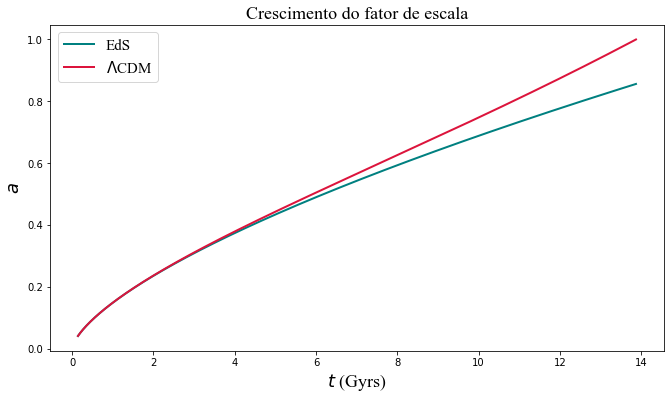

In [8]:
# Gráfico simples para mostrar que o fator de escala em LCDM crescre mais que o de EdS a partir de determinado ponto:

t_eixo_1 = np.linspace(0.01, t_0_LCDM, 10**4)

font_figA = {'family': 'Times New Roman', 'size': 15}
plt.figure(figsize=(11, 6))
plt.title('Crescimento do fator de escala', fontsize = 18, family = 'Times New Roman')
plt.plot(t_Gyrs(t_eixo_1), (a_LCDM(t_eixo_1[0])/a_EdS(t_eixo_1[0]))*a_EdS(t_eixo_1), color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2)
plt.plot(t_Gyrs(t_eixo_1), a_LCDM(t_eixo_1), color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2)
plt.ylabel('$a$', fontsize = 18, family = 'Times New Roman')
plt.xlabel('$t$ (Gyrs)', fontsize = 18, family = 'Times New Roman')
plt.legend(prop = font_figA)
plt.savefig('fatordeescala.pdf', bbox_inches = 'tight')
plt.show()

-----------------------------------

- Fator de crescimento linear:

-----------------------------------

$D_{EdS}(a) = a$

$D_{\Lambda CDM}(a) = a \, {}_2F_{1}\left[\dfrac{1}{3}, 1, \dfrac{11}{6}; -a^3\left(\dfrac{\Omega_{\Lambda 0}}{\Omega_{\textrm{m}0}}\right)\right]$

- Solução numérica:

$D(t_{\textrm{a}}) = \dfrac{5}{2} \Omega_{\textrm{m}0}H_{\textrm{a}} \int^{t'} \dfrac{dt}{a^2H^2_{\textrm{a}}}~$

In [9]:
# EdS:
    
# Solução analítica: 

def D_analitico_EdS(t):
    return a_EdS(t)

# Solução numérica:

def integral_EdS(t):
    integral, erro = quad(lambda t: 1/((a_EdS(t)*H_EdS(t))**2), t_i_EdS, t) # integrando numericamente e deixando o limite superior livre
    return integral


D_numerico_EdS = np.zeros(t_eixo_EdS.size) # criando um vetor para armazenar os valores
i = 0
for t in t_eixo_EdS:
    D_numerico_EdS[i] = (5/2)*omega_EdS*H_EdS(t)*integral_EdS(t)
    i += 1

#LCDM:

# Solução analítica:

def D_analitico_LCDM(t):
    return a_LCDM(t)*hyp2f1(1/3, 1, 11/6, -a_LCDM(t)**3*(omega_L_LCDM/omega_m_LCDM))

# Solução numérica:

def integral_LCDM(t):
    integral, erro = quad(lambda t: 1/((a_LCDM(t)*H_LCDM(t))**2), t_i_LCDM, t)
    return integral

D_numerico_LCDM = np.zeros_like(t_eixo_LCDM) # criando um vetor para armazenar os valores
i = 0
for t in t_eixo_LCDM:
    D_numerico_LCDM[i] = (5/2)*omega_m_LCDM*H_LCDM(t)*integral_LCDM(t)
    i += 1

# Em função do redshift:

def D_z_EdS(z):
    return a_z(z)

def D_z_LCDM(z):
    return a_z(z)*hyp2f1(1/3, 1, 11/6, -a_z(z)**3*(omega_L_LCDM/omega_m_LCDM))

# Redshift para os eixos:

def redshift_EdS(t):
    return 1/a_EdS(t) - 1

def redshift_LCDM(t):
    return 1/a_LCDM(t) - 1

z_eixo_EdS = redshift_EdS(t_eixo_EdS) 
z_eixo_LCDM = redshift_LCDM(t_eixo_LCDM)


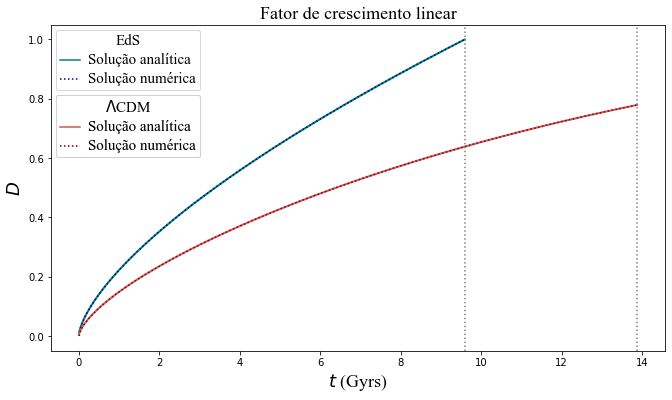

In [10]:
# Gráfico:

plt.figure(figsize=(11, 6))
plt.title('Fator de crescimento linear', fontsize = 18, family = 'Times New Roman')
plt.plot(t_Gyrs(t_eixo_EdS), D_analitico_EdS(t_eixo_EdS), color = 'teal', linestyle = '-', label = 'analítico', linewidth = 2) # Solução analítica em EdS
plt.plot(t_Gyrs(t_eixo_EdS), D_numerico_EdS, color = 'navy', linestyle = 'dotted', label = 'numérico') # Solução numérica em EdS
plt.plot(t_Gyrs(t_eixo_LCDM), D_analitico_LCDM(t_eixo_LCDM), color = 'indianred', linestyle = '-', label = 'analítico', linewidth = 2) # 'Solução analítica em $\Lambda$CDM'
plt.plot(t_Gyrs(t_eixo_LCDM), D_numerico_LCDM, color = 'darkred', linestyle = 'dotted', label = 'numérico') # 'Solução numérica em $\Lambda$CDM'
plt.xlabel('$t$ (Gyrs)', fontsize = 18, family = 'Times New Roman')
plt.ylabel('$D$', fontsize = 18, family = 'Times New Roman')
plt.axvline(t_Gyrs(t_0_EdS), color = 'gray', linestyle = 'dotted')
plt.axvline(t_Gyrs(t_0_LCDM), color = 'gray', linestyle = 'dotted')

# Legendas:
Legenda_EdS_D = plt.legend(handles=EdS_legenda, loc = 'upper left', title = 'EdS')
Legenda_EdS_D.get_title().set_fontsize('15')
Legenda_EdS_D.get_title().set_fontname('Times New Roman')
for text in Legenda_EdS_D.get_texts():
    text.set_fontsize('15')
    text.set_fontname('Times New Roman')
Legenda_LCDM_D = plt.legend(handles=LCDM_legenda, bbox_to_anchor = (0.25, 0.80), title = '$\Lambda$CDM')
Legenda_LCDM_D.get_title().set_fontsize('15')
Legenda_LCDM_D.get_title().set_fontname('Times New Roman')
for text in Legenda_LCDM_D.get_texts():
    text.set_fontsize('15')
    text.set_fontname('Times New Roman')

plt.gca().add_artist(Legenda_EdS_D) # Adicionando as legendas ao gráfico
plt.gca().add_artist(Legenda_LCDM_D)
plt.savefig('crescimentolinear.pdf', bbox_inches = 'tight')
plt.show()

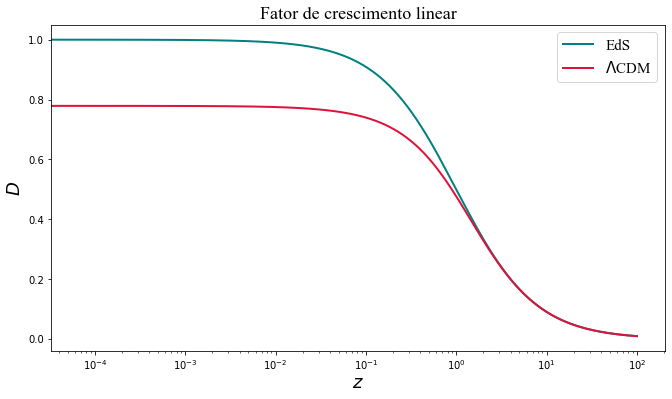

In [11]:
# Gráfico simples para mostrar que o fator de escala em LCDM crescre mais que o de EdS a partir de determinado ponto:

plt.figure(figsize=(11, 6))
plt.title('Fator de crescimento linear', fontsize = 18, family = 'Times New Roman')
plt.plot(z_eixo_EdS, D_z_EdS(z_eixo_EdS), color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2) # Solução analítica em EdS
plt.plot(z_eixo_LCDM, D_z_LCDM(z_eixo_LCDM), color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2) # 'Solução analítica em $\Lambda$CDM'
plt.xlabel('$z$', fontsize = 18, family = 'Times New Roman')
plt.ylabel('$D$', fontsize = 18, family = 'Times New Roman')
plt.xscale('log')
plt.legend(prop = font_figA)
plt.savefig('crescimentoredshift.pdf', bbox_inches = 'tight')
plt.show()

-----------------------------------

- Colapso esférico:

-----------------------------------

- Soluções analíticas para EdS:

$t_{\textrm{a}}(\theta) = (\theta - \sin{\theta})\dfrac{\Omega_{\textrm{m}0}(1 + \delta_i)}{2}\left[\dfrac{\Omega_{\textrm{m}0}(1 + \delta_i)}{a_i} - H_{\textrm{a},i}^2 a_i^2\right]^{-3/2}$

$R_{\textrm{a}}(\theta) = \dfrac{\cos{\theta} - 1}{2}\left[\dfrac{\Omega_{\textrm{m}0}(1 + \delta_i)}{a_i^3 H_{\textrm{a}, i}^2 - \Omega_{\textrm{m}0}(1 + \delta_i)}\right]$

$\delta = \dfrac{9(\theta - \sin{\theta})^2}{2(1 - \cos{\theta})^3} - 1$

$\delta = \dfrac{3}{20}6^{2/3}\left(\theta - \sin{\theta}\right)^{2/3}$

In [12]:
theta_i = 0
theta_turn = np.pi
theta_collapse = 0.99*2*np.pi # para evitar divergências
theta_eixo = np.linspace(theta_i, theta_collapse, 10**4)

def t_EdS_theta(eta, delta_i): # tempo analítico
    return (eta - np.sin(eta))*(omega_EdS*(1 + delta_i)/2)/((omega_EdS*(1 + delta_i)/a_EdS_i) - (a_EdS_i**2)*(H_EdS_i**2))**(3/2)

def R_analitico_theta(eta, delta_i): # raio analítico
    return ((np.cos(eta) - 1)/2)*((omega_EdS*(1 + delta_i))/((a_EdS_i**3)*(H_EdS_i**2) - omega_EdS*(1 + delta_i)))

def delta_analitico_theta(eta): # contraste não linear
    return (9*(eta - np.sin(eta))**2)/(2*(1 - np.cos(eta))**3) - 1

def extrapolacao_linear(eta):
    return (3/20)*(6**(2/3))*(eta - np.sin(eta))**(2/3)

C:\Users\laura\AppData\Local\Temp\ipykernel_16028\3938400028.py:13: RuntimeWarning: invalid value encountered in divide
  return (9*(eta - np.sin(eta))**2)/(2*(1 - np.cos(eta))**3) - 1


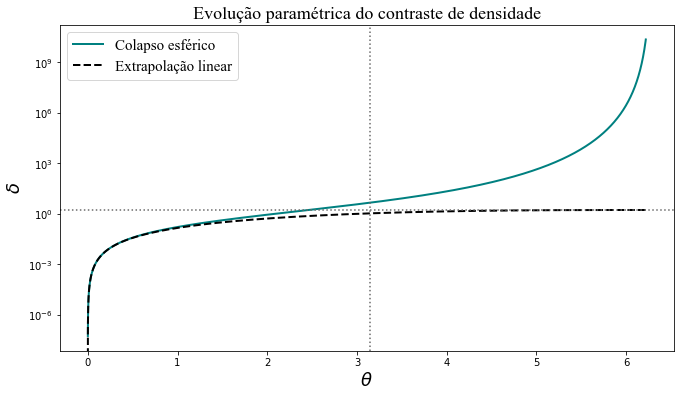

In [13]:
# Gráficos paramétricos:

font_figSCtheta = {'family': 'Times New Roman', 'size': 15}
plt.figure(figsize=(11, 6))
plt.title('Evolução paramétrica do contraste de densidade', fontsize = 18, family = 'Times New Roman')
plt.plot(theta_eixo, delta_analitico_theta(theta_eixo), color = 'teal', linestyle = '-', label = 'Colapso esférico', linewidth = 2)
plt.plot(theta_eixo, extrapolacao_linear(theta_eixo), color = 'k', linestyle = '--', label = 'Extrapolação linear', linewidth = 2)
plt.ylabel('$\delta$', fontsize = 18, family = 'Times New Roman')
plt.xlabel('$θ$', fontsize = 18, family = 'Times New Roman')
plt.yscale('log')
plt.axvline(x = np.pi, color = "dimgray", linestyle = 'dotted') # Linha vertical: momento de turn-around
plt.axhline(y = 1.69, color = "dimgray", linestyle = 'dotted') # Linha horizontal: previsão linear para o colapso
plt.legend(prop = font_figSCtheta)
plt.savefig('SCtheta.pdf', bbox_inches = 'tight')
plt.show()

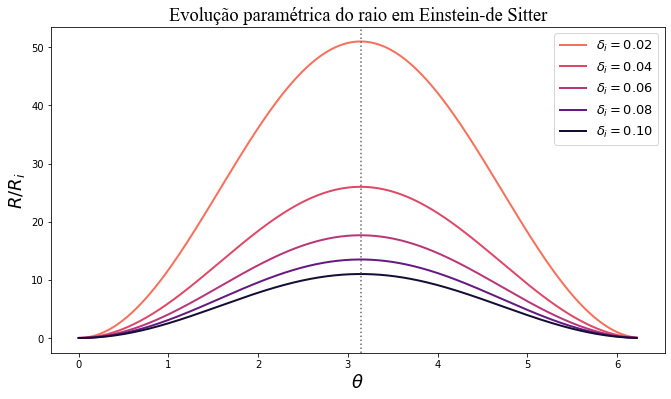

In [14]:
cmap = cm.get_cmap('magma') # mapa de cores para plotar várias linhas na mesma paleta de cores
font_figRtheta = {'family': 'Times New Roman', 'size': 13}
plt.figure(figsize=(11, 6))
plt.title('Evolução paramétrica do raio em Einstein-de Sitter', fontsize = 18.5, family = 'Times New Roman')
plt.plot(theta_eixo, R_analitico_theta(theta_eixo, 0.02), color = cmap(0.7), linestyle = '-', label = '$\delta_i = 0.02$', linewidth = 2)
plt.plot(theta_eixo, R_analitico_theta(theta_eixo, 0.04), color = cmap(0.6), linestyle = '-', label = '$\delta_i = 0.04$', linewidth = 2)
plt.plot(theta_eixo, R_analitico_theta(theta_eixo, 0.06), color = cmap(0.5), linestyle = '-', label = '$\delta_i = 0.06$', linewidth = 2)
plt.plot(theta_eixo, R_analitico_theta(theta_eixo, 0.08), color = cmap(0.3), linestyle = '-', label = '$\delta_i = 0.08$', linewidth = 2)
plt.plot(theta_eixo, R_analitico_theta(theta_eixo, 0.10), color = cmap(0.1), linestyle = '-', label = '$\delta_i = 0.10$', linewidth = 2)
plt.xlabel(r'$\theta$', fontsize = 18, family = 'Times New Roman')
plt.ylabel(r'$R/R_i$', fontsize = 18, family = 'Times New Roman')
plt.axvline(x = theta_turn, color = "dimgray", linestyle = 'dotted')
plt.legend(prop = font_figRtheta)
plt.savefig('raiosEdSparametrico.pdf', bbox_inches = 'tight')
plt.show()

------------

- Solução numérica:

In [15]:
# Condições iniciais necessárias para a solução numérica: 

R_EdS_i = 1
R_linha_EdS_i = H_EdS_i

R_LCDM_i = 1
R_linha_LCDM_i = H_LCDM_i

# Diferentes valores possíveis para delta_i:

delta_i_1 = 0.05 
delta_i_2 = 0.03636 # colapso em z = 0 em LCDM
delta_i_3 = 0.02836 # colapso em z = 0 em EdS
delta_i_4 = 0.02525 # valor mínimo para que haja colapso
delta_i_5 = 0.02524 # não há mais colapso

delta_i_lista = [delta_i_1, delta_i_2, delta_i_3, delta_i_4, delta_i_5]

- EdS:

$a' = \sqrt{\dfrac{\Omega_{\textrm{m}0}}{a}}$

$R_{\textrm{a}}'' = \dfrac{-\Omega_{\textrm{m}0}(1 + \delta_i)}{2a^3_iR^2_{\textrm{a}}}$

$\delta' = -3(1 + \delta) \left(\dfrac{R_\textrm{a}'}{R_\textrm{a}} - \dfrac{a'}{a}\right)$

In [16]:
# Solução numérica para EdS:

def sistemaEdS(t, f, delta_i):

    a, R, aux, delta = f

    a_linha = np.sqrt(omega_EdS/a)

    R_linha = aux

    R_duas_linhas = -omega_EdS*(1 + delta_i)/(2*(a_EdS_i**3)*(R**2))

    delta_linha = 3*(1 + delta)*((a_linha/a) - (R_linha/R)) 

    return [a_linha, R_linha, R_duas_linhas, delta_linha]

- $\Lambda\textrm{CDM}$:

$a' = a\sqrt{\dfrac{\Omega_{\textrm{m}0}}{a^3} + \Omega_{\Lambda 0}}$

$R''_{\textrm{a}} = \Omega_{\Lambda 0}R_{\textrm{a}} - \dfrac{\Omega_{\textrm{m}0}(1 + \delta_i)}{2a^3_i R^2_{\textrm{a}}}$

$\delta' = -3(1 + \delta) \left(\dfrac{R_\textrm{a}'}{R_\textrm{a}} - \dfrac{a'}{a}\right)$

In [17]:
# Solução numérica para LCDM:

def sistemaLCDM(t, f, delta_i):

    a, R, aux, delta = f

    a_linha = a*np.sqrt(omega_m_LCDM/a**3 + omega_L_LCDM)

    R_linha = aux

    R_duas_linhas = omega_L_LCDM*R - omega_m_LCDM*(1 + delta_i)/(2*(a_LCDM_i**3)*(R**2))

    delta_linha = 3*(1 + delta)*((a_linha/a) - (R_linha/R))

    return [a_linha, R_linha, R_duas_linhas, delta_linha]


In [18]:
# Para cada valor de delta_i, é necessário um eixo temporal diferente, que acaba no instante de colapso

# Para armazenar os valores:

t_f_EdS_lista = []
t_eixo_EdS_lista = []
a_EdS_numerico_lista = []
R_EdS_numerico_lista = []
delta_EdS_numerico_lista = []

t_f_LCDM_lista = [0.556, t_0_LCDM, 1.757, 5.762, 5.762] # Calculado por tentativa e erro # 1.482
t_eixo_LCDM_lista = []
a_LCDM_lista = []
R_LCDM_lista = []
delta_LCDM_lista = []

# Calculando eixos temporais para cada delta_i:

for delta_i, t_f_LCDM_aux in zip(delta_i_lista, t_f_LCDM_lista):

    t_f_EdS_aux = t_EdS_theta(theta_collapse, delta_i) # Calculado a partir da solução analítica, para que acabe no instante do colapso
    t_f_EdS_lista.append(t_f_EdS_aux)
    t_eixo_EdS_aux = np.linspace(t_i_EdS, t_f_EdS_aux, 10**4)
    t_eixo_EdS_lista.append(t_eixo_EdS_aux)
    t_eixo_LCDM_aux = np.linspace(t_i_LCDM, t_f_LCDM_aux, 10**4)
    t_eixo_LCDM_lista.append(t_eixo_LCDM_aux)
    
    solucao_EdS_SC = solve_ivp(sistemaEdS, [t_i_EdS, t_f_EdS_aux], [a_EdS_i, R_EdS_i, R_linha_EdS_i, delta_i],  t_eval = t_eixo_EdS_aux, args = (delta_i, ), dense_output = True)
    a_EdS_numerico_lista.append(solucao_EdS_SC.y[0])
    R_EdS_numerico_lista.append(solucao_EdS_SC.y[1])
    delta_EdS_numerico_lista.append(solucao_EdS_SC.y[3])

    solucao_LCDM_SC = solve_ivp(sistemaLCDM, [t_i_LCDM, t_f_LCDM_aux], [a_LCDM_i, R_LCDM_i, R_linha_LCDM_i, delta_i], t_eval = t_eixo_LCDM_aux, args = (delta_i, ), dense_output= True)
    a_LCDM_lista.append(solucao_LCDM_SC.y[0])
    R_LCDM_lista.append(solucao_LCDM_SC.y[1])
    delta_LCDM_lista.append(solucao_LCDM_SC.y[3])

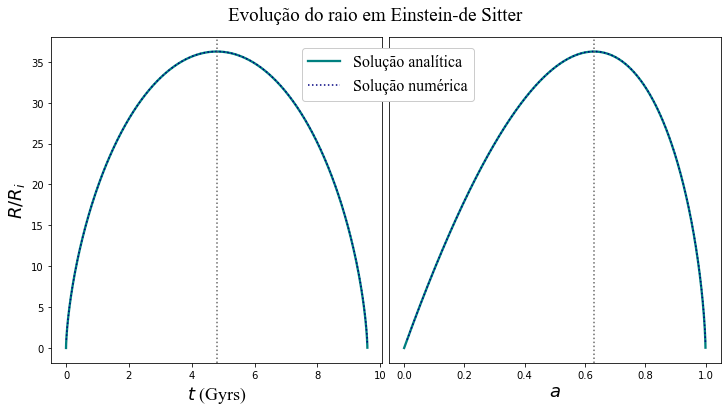

In [19]:
# Gráficos:

font_figR = {'family': 'Times New Roman', 'size': 16}
figR, (plotR1, plotR2) = plt.subplots(1, 2, figsize = (12, 6))

plt.suptitle('Evolução do raio em Einstein-de Sitter', fontsize = 19, family = 'Times New Roman', y = 0.95)
plotR1.plot(t_Gyrs(t_EdS_theta(theta_eixo, delta_i_lista[2])), R_analitico_theta(theta_eixo, delta_i_lista[2]), color = 'teal', linestyle = '-', label = 'Solução analítica', linewidth = 2.3)
plotR1.plot(t_Gyrs(t_eixo_EdS_lista[2]), R_EdS_numerico_lista[2], color = 'navy', linestyle = 'dotted', label = 'Solução numérica')
plotR1.set_ylabel('$R/R_i$', fontsize = 18, family = 'Times New Roman')
plotR1.set_xlabel('$t$ (Gyrs)', fontsize = 18, family = 'Times New Roman')
plotR1.axvline(x = t_Gyrs(t_EdS_theta(theta_turn, delta_i_lista[2])), color = 'dimgray', linestyle = 'dotted') # Linha vertical: momento de turn-around
# plotR1.axvline(x = t_Gyrs(t_0_EdS), color = 'dimgray', linestyle = 'dotted')

plotR2.plot(a_EdS(t_EdS_theta(theta_eixo, delta_i_lista[2])), R_analitico_theta(theta_eixo, delta_i_lista[2]), color = 'teal', linestyle = '-', label = 'Solução analítica', linewidth = 2.3)
plotR2.plot(a_EdS_numerico_lista[2], R_EdS_numerico_lista[2], color = 'navy', linestyle = 'dotted', label = 'Solução numérica')
plotR2.set_ylabel('')
plotR2.set_xlabel('$a$', fontsize = 18, family = 'Times New Roman')
plotR2.axvline(x = a_EdS(t_EdS_theta(theta_turn, delta_i_lista[2])), color = 'dimgray', linestyle = 'dotted') # Linha vertical: momento de turn-around
plotR2.legend(prop = font_figR, bbox_to_anchor = (0.28, 0.99)).get_frame().set_alpha(1)
plotR2.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)

plt.subplots_adjust(wspace=0.02)
plt.savefig('raioEdS.pdf', bbox_inches = 'tight')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_16028\3938400028.py:13: RuntimeWarning: invalid value encountered in divide
  return (9*(eta - np.sin(eta))**2)/(2*(1 - np.cos(eta))**3) - 1


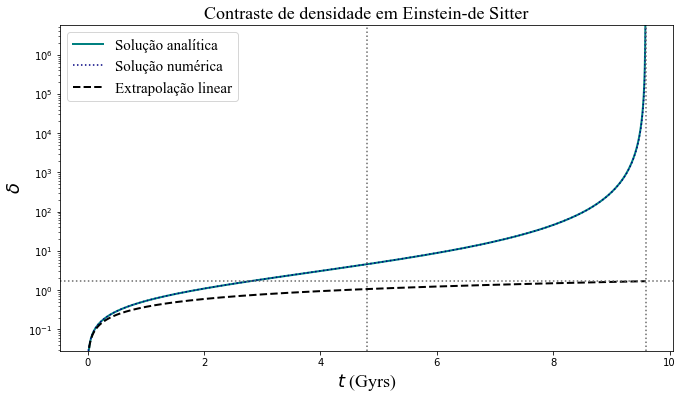

In [20]:
font_figSC = {'family': 'Times New Roman', 'size': 15}
plt.figure(figsize=(11, 6))
plt.title('Contraste de densidade em Einstein-de Sitter', fontsize = 18, family = 'Times New Roman')
plt.plot(t_Gyrs(t_EdS_theta(theta_eixo, delta_i_lista[2])), delta_analitico_theta(theta_eixo), color = 'teal', linestyle = '-', label = 'Solução analítica', linewidth = 2)
plt.plot(t_Gyrs(t_eixo_EdS_lista[2]), delta_EdS_numerico_lista[2], color = 'navy', linestyle = 'dotted', label = 'Solução numérica')
plt.plot(t_Gyrs(t_EdS_theta(theta_eixo, delta_i_lista[2])), extrapolacao_linear(theta_eixo), color = 'k', linestyle = '--', label = 'Extrapolação linear', linewidth = 2)
plt.axvline(x = t_Gyrs(t_EdS_theta(theta_turn, delta_i_lista[2])), color = "dimgray", linestyle = 'dotted') # Linha vertical: momento de turn-around
plt.axvline(x = t_Gyrs(t_EdS_theta(theta_collapse, delta_i_lista[2])), color = "dimgray", linestyle = 'dotted') # Linha vertical mais à direita: colapso
plt.axhline(y = 1.69, color = 'dimgrey', linestyle = 'dotted') # Linha horizontal: previsão para a virialização
plt.xlabel('$t$ (Gyrs)', fontsize = 18, family = 'Times New Roman')
plt.ylabel('$\delta$', fontsize = 18, family = 'Times New Roman')
plt.yscale('log')
plt.ylim(delta_EdS_numerico_lista[2][0], delta_EdS_numerico_lista[2][-1]) # (0, 2) # x: (0, t_Gyrs(t_EdS_theta(theta_collapse, delta_i_lista[-1])))
plt.legend(prop = font_figSC)
plt.savefig('SCemEdS.pdf', bbox_inches = 'tight')
plt.show()

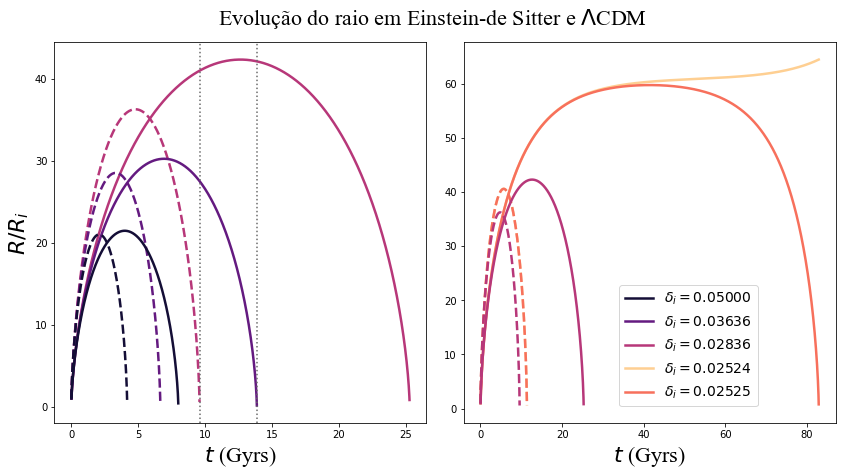

In [21]:
# Soluções para cada delta_i:

font_figR2 = {'size': 14}
figR2, (plotR21, plotR22) = plt.subplots(1, 2, figsize = (14, 7))
plt.suptitle('Evolução do raio em Einstein-de Sitter e $\Lambda$CDM', fontsize = 22, family = 'Times New Roman', y = 0.95)

plotR21.plot(t_Gyrs(t_eixo_EdS_lista[2]), R_EdS_numerico_lista[2], color = cmap(0.5), linestyle = '--', linewidth = 2.5)
plotR21.plot(t_Gyrs(t_eixo_LCDM_lista[2]), R_LCDM_lista[2], color = cmap(0.5), linestyle = '-', label = '$\delta_i = 0.02836$', linewidth = 2.5)
plotR21.plot(t_Gyrs(t_eixo_EdS_lista[1]), R_EdS_numerico_lista[1], color = cmap(0.3), linestyle = '--', linewidth = 2.5)
plotR21.plot(t_Gyrs(t_eixo_LCDM_lista[1]), R_LCDM_lista[1], color = cmap(0.3), linestyle = '-', label = '$\delta_i = 0.03636$', linewidth = 2.5)
plotR21.plot(t_Gyrs(t_eixo_EdS_lista[0]), R_EdS_numerico_lista[0], color = cmap(0.1), linestyle = '--', linewidth = 2.5)
plotR21.plot(t_Gyrs(t_eixo_LCDM_lista[0]), R_LCDM_lista[0], color = cmap(0.1), linestyle = '-', label = '$\delta_i = 0.05000$', linewidth = 2.5)
plotR21.set_xlabel('$t$ (Gyrs)', fontsize = 22, family = 'Times New Roman')
plotR21.set_ylabel('$R/R_i$', fontsize = 22, family = 'Times New Roman')
plotR21.axvline(x = t_Gyrs(t_0_LCDM), linestyle = 'dotted', color = 'dimgray') # z = 0 em LCDM
plotR21.axvline(x = t_Gyrs(t_0_EdS), linestyle = 'dotted', color = 'dimgray') # z = 0 em LCDM

plotR22.plot([], [], color = cmap(0.1), linestyle = '--', linewidth = 2.5) # Para legendar o primeiro gráfico no segundo, mas não aparecerem as linhas novamente
plotR22.plot([], [], color = cmap(0.1), linestyle = '-', label = '$\delta_i = 0.05000$', linewidth = 2.5)
plotR22.plot([], [], color = cmap(0.3), linestyle = '--', linewidth = 2.5)
plotR22.plot([], [], color = cmap(0.3), linestyle = '-', label = '$\delta_i = 0.03636$', linewidth = 2.5)
plotR22.plot([], [], color = cmap(0.5), linestyle = '--', linewidth = 2.5) 
plotR22.plot([], [], color = cmap(0.5), linestyle = '-', label = '$\delta_i = 0.02836$', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_EdS_lista[4]), R_EdS_numerico_lista[4], color = cmap(0.9), linestyle = '--', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_LCDM_lista[4]), R_LCDM_lista[4], color = cmap(0.9), linestyle = '-', label = '$\delta_i = 0.02524$', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_EdS_lista[3]), R_EdS_numerico_lista[3], color = cmap(0.7), linestyle = '--', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_LCDM_lista[3]), R_LCDM_lista[3], color = cmap(0.7), linestyle = '-', label = '$\delta_i = 0.02525$', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_EdS_lista[2]), R_EdS_numerico_lista[2], color = cmap(0.5), linestyle = '--', linewidth = 2.5)
plotR22.plot(t_Gyrs(t_eixo_LCDM_lista[2]), R_LCDM_lista[2], color = cmap(0.5), linestyle = '-', label = '', linewidth = 2.5)
plotR22.set_xlabel('$t$ (Gyrs)', fontsize = 22, family = 'Times New Roman')
plotR22.set_ylabel('')
plotR22.legend(prop = font_figR2, bbox_to_anchor = (0.4, 0.38))

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.savefig('raiosSCcomparacao.pdf', bbox_inches = 'tight')
plt.show()

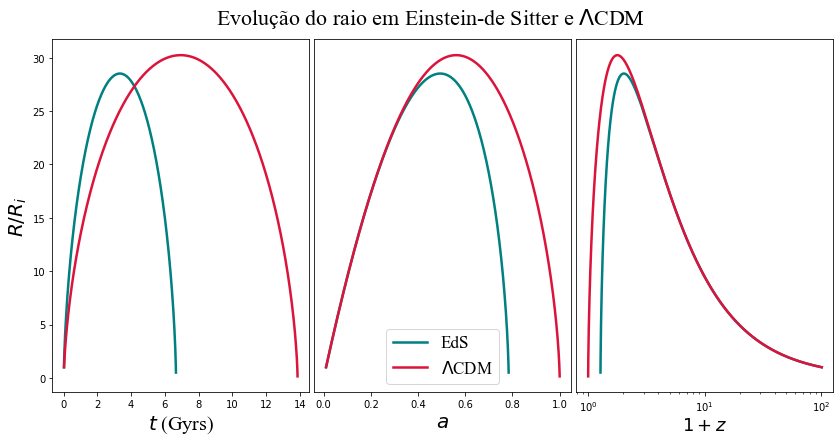

In [22]:
font_figLCDM = {'family': 'Times New Roman', 'size': 17}
figLCDM, (plotRL1, plotRL2, plotRL3) = plt.subplots(nrows=1, ncols=3, figsize = (14, 6.5))
plt.suptitle('Evolução do raio em Einstein-de Sitter e $\Lambda$CDM', fontsize = 22, family = 'Times New Roman', y = 0.95)
plotRL1.plot(t_Gyrs(t_eixo_EdS_lista[1]), R_EdS_numerico_lista[1], color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2.5)
plotRL1.plot(t_Gyrs(t_eixo_LCDM_lista[1]), R_LCDM_lista[1], color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2.5)
plotRL1.set_ylabel('$R/R_i$', fontsize = 20, family = 'Times New Roman')
plotRL1.set_xlabel('$t$ (Gyrs)', fontsize = 20, family = 'Times New Roman')

plotRL2.plot(a_EdS(t_eixo_EdS_lista[1]), R_EdS_numerico_lista[1], color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2.5)
plotRL2.plot(a_LCDM(t_eixo_LCDM_lista[1]), R_LCDM_lista[1], color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2.5)
plotRL2.set_ylabel('', fontsize = 20, family = 'Times New Roman')
plotRL2.set_xlabel('$a$', fontsize = 20, family = 'Times New Roman')
plotRL2.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
plotRL2.legend(prop = font_figLCDM)

plotRL3.plot(1 + redshift_EdS(t_eixo_EdS_lista[1]), R_EdS_numerico_lista[1], color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2.5)
plotRL3.plot(1 + redshift_LCDM(t_eixo_LCDM_lista[1]), R_LCDM_lista[1], color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2.5)
plotRL3.set_ylabel('', fontsize = 20, family = 'Times New Roman')
plotRL3.set_xlabel('$1 + z$', fontsize = 18, family = 'Times New Roman')
plotRL3.set_xscale('log')
plotRL3.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
plt.subplots_adjust(wspace=0.02)
plt.savefig('raiosLCDMhoje.pdf', bbox_inches = 'tight')
plt.show()

-------------

- Contraste de colapso: 

$\delta_{L}^{\Lambda CDM} = \left[\dfrac{\delta_L^{EdS}(t_i)}{D^{EdS}(t_i)}\right]D^{\Lambda CDM}(t)$

In [23]:
# Determinação de delta_c para LCDM:

def contraste_linear(t, delta_i): # extrapolação linear em função do tempo
    return (3*12**(2/3)/20)*((omega_EdS*(1 + delta_i))**(1/3)/a_EdS_i - (H_EdS_i*a_EdS_i)**2/(omega_EdS*(1 + delta_i))**(2/3))*t**(2/3)

C = contraste_linear(t_i_EdS, delta_i_lista[1])/D_analitico_EdS(t_i_EdS) # constante de normalização

# def extrapolacao_linear_EdS_normalizada(t):
#     return C*D_analitico_EdS(t)

# def extrapolacao_linear_LCDM_normalizada(t):
#     return C*D_analitico_LCDM(t)

delta_collapse_EdS = C*D_analitico_EdS(t_eixo_EdS_lista[1][-1])
delta_collapse_LCDM = C*D_analitico_LCDM(t_eixo_LCDM_lista[1][-1])

print(f"O valor de delta_c em EdS é {round(delta_collapse_EdS, 3)}. O valor esperado é de {round(extrapolacao_linear(theta_collapse), 3)}.")
print(f"O valor de delta_c em LCDM é {round(delta_collapse_LCDM, 3)} em z = 0.")

O valor de delta_c em EdS é 1.686. O valor esperado é de 1.686.
O valor de delta_c em LCDM é 1.676 em z = 0.


-----------

- Para o contraste de virialização:

$2\eta \left(\dfrac{R_v}{R_t}\right)^3 - (2 + \eta) \left(\dfrac{R_v}{R_t}\right) + 1 = 0$

$\eta = \dfrac{2\Omega_{\Lambda 0}a^3_iR^3_t}{\Omega_{m0}(1 + \delta_i)}$

In [24]:
# Encontrando o raio de turn-around (escolhendo o colapso em z = 0 em LCDM):

R_t_EdS, R_t_EdS_indice = max((R, R_indice) for R_indice, R in enumerate(R_EdS_numerico_lista[1])) # encontrando o valor máximo no vetor
R_t_LCDM, R_t_LCDM_indice = max((R, R_indice) for R_indice, R in enumerate(R_LCDM_lista[1])) # encontrando o valor máximo no vetor

# Resolvendo a equação para EdS:
R_v_EdS = symbols('R_v_EdS')
eta_EdS = 0
eq_EdS = Eq(2 * eta_EdS * (R_v_EdS / R_t_EdS)**3 - (2 + eta_EdS) * (R_v_EdS / R_t_EdS) + 1, 0)
R_v_EdS = solve(eq_EdS, R_v_EdS)[0] # índice só para tirar do vetor
print(f"O raio de virialização em EdS é {round(R_v_EdS, 3)}. O valor esperado é de {round(R_t_EdS/2, 3)}.")

# Resolvendo para LCDM:
R_v_LCDM = symbols('R_v_LCDM')
eta_LCDM = (2*omega_L_LCDM*(a_LCDM_i**3)*(R_t_LCDM**3))/(omega_m_LCDM*(1 + delta_i_lista[1]))
eq_LCDM = Eq(2*eta_LCDM*(R_v_LCDM/R_t_LCDM)**3 - (2 + eta_LCDM)*(R_v_LCDM/R_t_LCDM) + 1, 0)
solucoes_LCDM = solve(eq_LCDM, R_v_LCDM)
print(f"As soluções para o raio de virialização em LCDM são {solucoes_LCDM[0]}, {solucoes_LCDM[1]} e {solucoes_LCDM[2]}.")
# Ao fazer isso, existem 3 soluções e duas são facilmente elimináveis (uma negativa e uma maior que R_t_LCDM) então escolhemos a única possível
# O resultado encontrado tem uma parte de e-19 imaginária (dentro da margem de erro da máquina), por isso o nsimplify
# A multiplicação por 1.0 vem para transformar esse número em float

R_v_LCDM = nsimplify(solucoes_LCDM[1])*1.0

# Podemos comparar com o resultado esperando pela aproximação em Batista (2022)
R_v_2 = R_t_LCDM*(1 - eta_LCDM/2)/(2 - eta_LCDM/2)
print(R_v_2)

print(f"Eliminando soluções fisicamente impossíveis, raio de virialização em LCDM é {round(R_v_LCDM, 3)}.")

O raio de virialização em EdS é 14.255. O valor esperado é de 14.255.
As soluções para o raio de virialização em LCDM são -96.0043287773036 + 0.e-21*I, 14.6470744092569 + 0.e-19*I e 81.3572543680468 + 0.e-19*I.
14.645727893968639
Eliminando soluções fisicamente impossíveis, raio de virialização em LCDM é 14.647.


$\delta_v = \dfrac{(1 + \delta_i)a^3_v}{a^3_i R^3_{a,v}} - 1$

In [25]:
# Para EdS (teste):
a_v_EdS = a_EdS(t_f_EdS_lista[1]) # fator de escala no instante de colapso
delta_v_EdS = ((1 + delta_i_lista[1])*a_v_EdS**3)/((a_EdS_i*R_v_EdS)**3) - 1
print(f"Contraste de virialização em EdS: {round(delta_v_EdS, 3)}.") 

# LCDM:
a_v_LCDM = a_LCDM(t_f_LCDM_lista[1])
delta_v_LCDM = ((1 + delta_i_lista[1])*a_v_LCDM**3)/((a_LCDM_i*R_v_LCDM)**3) - 1
print(f"Contraste de virialização em LCDM: {round(delta_v_LCDM, 3)}")


Contraste de virialização em EdS: 176.508.
Contraste de virialização em LCDM: 338.799


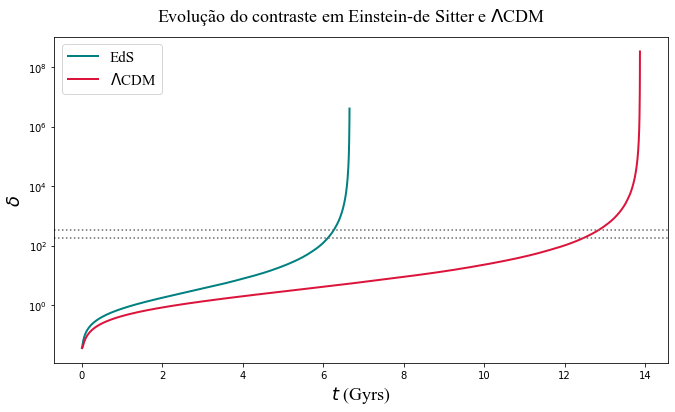

In [26]:
plt.figure(figsize=(11, 6))
plt.suptitle('Evolução do contraste em Einstein-de Sitter e $\Lambda$CDM', fontsize = 18, family = 'Times New Roman', y = 0.95)
plt.plot(t_Gyrs(t_eixo_EdS_lista[1]), delta_EdS_numerico_lista[1], color = 'teal', linestyle = '-', label = 'EdS', linewidth = 2)
plt.plot(t_Gyrs(t_eixo_LCDM_lista[1]), delta_LCDM_lista[1], color = 'crimson', linestyle = '-', label = '$\Lambda$CDM', linewidth = 2)
plt.yscale('log')
plt.xlabel('$t$ (Gyrs)', fontsize = 18, family = 'Times New Roman')
plt.ylabel('$\delta$', fontsize = 18, family = 'Times New Roman')
plt.axhline(y = delta_v_EdS, linestyle = 'dotted', color = 'dimgray')
plt.axhline(y = delta_v_LCDM , linestyle = 'dotted', color = 'dimgray') 
plt.legend(prop = font_figSCtheta)
plt.savefig('SCcomparacao.pdf', bbox_inches = 'tight')
plt.show()

--------------------------

Formalismo de Press-Schechter

--------------------

- Para deixar as unidades em $M_{\odot} = 1.989 \cdot 10^{30} \dfrac{\textrm{kg}}{\textrm{m}^3}$ e $Mpc = 3.086 \cdot 10^{22} m$: 

In [51]:
print(f"Densidade do em z = 0 em EdS: {rho_0_EdS} km/m^3")
print(f"Densidade do em z = 0 em LCDM: {rho_0_LCDM} km/m^3")

# Para ficar em massas solares por Mpc:
def kmm3_para_MsunMpc3(densidade):
    return densidade*(3.086e22)**3/(1.989e30) # Converte kg para massas solares com Msun = 1.989e30 kg e m^3 para Mpc^3 com Mpc = 3.086e22

rho_0_EdS_1 = kmm3_para_MsunMpc3(rho_0_EdS)
rho_0_LCDM_1 = kmm3_para_MsunMpc3(rho_0_LCDM)

print(f"Densidade do em z = 0 em EdS: {rho_0_EdS_1} M_o/Mpc^3")
print(f"Densidade do em z = 0 em LCDM: {rho_0_LCDM_1} M_o/Mpc^3")


Densidade do em z = 0 em EdS: 8.68363685764759e-27 km/m^3
Densidade do em z = 0 em LCDM: 2.6050910572942768e-27 km/m^3
Densidade do em z = 0 em EdS: 128308265873.83621 M_o/Mpc^3
Densidade do em z = 0 em LCDM: 38492479762.15086 M_o/Mpc^3


In [52]:
def a_z(z): # fator de escala em função do redshift:
    return 1/(1 + z)

# Densidade em função do redshift:

def rho_z(z):
    return rho_0_LCDM_1/(a_z(z)**3)

- Fator de crescimento linear:

In [53]:
def D_z(z):
    normalizacao = a_z(0)*hyp2f1(1/3, 1, 11/6, -a_z(0)**3*(omega_L_LCDM/omega_m_LCDM)) # para D(z = 0) = 1
    return a_z(z)*hyp2f1(1/3, 1, 11/6, -a_z(z)**3*(omega_L_LCDM/omega_m_LCDM))/normalizacao

- $\delta_c$: 

In [54]:
def delta_c_LCDM(z):
    return (delta_collapse_LCDM/D_z(0))*D_z(z) # Dando errado!

# Fit:

def H_z_1(z): # adimensional: H/H_0
    return np.sqrt(omega_m_LCDM/a_z(z)**3 + omega_L_LCDM)

def omega_z(z):
    return omega_m_LCDM/((a_z(z)*H_z_1(z))**3)

def fit_kitayama(z):
    return ((3/20)*(12*np.pi)**(2/3))*(1 + 0.0123*np.log(omega_z(z)))

- Função de transferência de Einsenstein & Hu:

In [55]:
omega_b = 0.048 # densidade de bárions
omega_T = omega_m_LCDM # densidade de matéria total
Tcmb = 2.7255
fB = omega_b/omega_T

alpha = 1 - 0.328*np.log(431*omega_T*h**2)*fB + 0.38*np.log(22.3*omega_T*h**2)*fB**2
s = 44.5*np.log(9.83/(omega_T*h**2))/(np.sqrt(1 + 10*(omega_b*h**2)**(3/4)))
tcmb = Tcmb/2.7 # flutuações em relação a 2.7K
Gamma0 = omega_T*h

def GammaEff(k):
    return Gamma0*(alpha + (1 - alpha)/(1 + (0.43*k*s)**4))

def q(k):
    return k*tcmb**2/(h*GammaEff(k))

def L(k):
    return np.log(2*np.e + 1.8*q(k))

def C(k):
    return 14.2 + (731)/(1 + 62.5*q(k))

def funcao_de_transferencia(k):
    return L(k)/(L(k) + C(k)*q(k)**2)

- Função janela:
$W(k, R) = \dfrac{3\left[\sin{(kR) - kR\cos{(kR)}}\right]}{(kR)^3}$

In [56]:
def funcao_janela(k, R):
    return 3*(np.sin(R*k) - R*k*np.cos(R*k))/((R*k)**3)

- Relação entre o raio e a massa: $R = \left(\dfrac{3M}{4\pi \bar{\rho}}\right)^{1/3}$

- Intervalo de massas: $M = [10^{10} M_{\odot}, \ 10^{15} M_{\odot}]$

In [57]:
# Eixo de raios e massas

def R_func(M, z):
    return ((3*M)/(4*np.pi*rho_z(z)))**(1/3)

M_eixo = np.logspace(9, 15, 70) # np.logspace(10, 15, 70) # em massas solares

- Parâmetros observacionais:

In [58]:
n = 0.9626 # (Planck18)
sigma8 = 0.8118 # (Planck18)
R8 = 8/h # Mpc

- Normalizando $\sigma^2$ com $\sigma_8 \equiv \sigma(R = 8h^{-1} \textrm{Mpc}, z = 0)$:

Como $\sigma^2(R, z) = A \int_0^{\infty} dk \, k^{2 + n} \, T^2(k) \, D^2(z) \, W^2(k, R)$, então

$A = \sigma^2_8 \left[\int_0^{\infty} dk \, k^{2 + n} \, T^2(k) \, D^2(0) \, W^2(k, R = 8h^{-1} Mpc)\right]^{-1}$

In [59]:
def integral_sigma2(R, z):
    D_z_salvo = D_z(z) # calculando antes para otimizar o código
    integral, erro = quad_vec(lambda k: (k**(2 + n))*(funcao_de_transferencia(k)*D_z_salvo*funcao_janela(k, R))**2, 0, np.inf)
    return integral

A = sigma8**2/integral_sigma2(R8, 0)

# Variância:
def sigma2(R, z):
    return A*integral_sigma2(R, z)

$\Delta^2(k, t) = \dfrac{k^3}{2\pi^2} \, P(k, t) = A \, k^{3 + n} \, T^2(k) \, D^2(z).$

In [60]:
def Delta2(k, z): # espectro de potência adimensional:
    return A*(k**(3 + n))*(funcao_de_transferencia(k)**2)*(D_z(z)**2)

def P(k, z): # espectro de potência
    return 2*(np.pi**2)*Delta2(k, z)/k**3

k_eixo = np.linspace(1/10**(3), 1.5, 10**3)

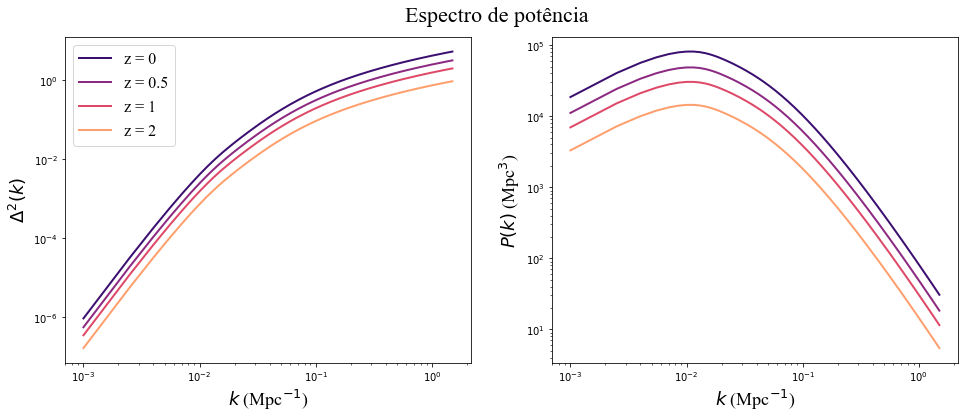

In [61]:
font_figPk = {'family': 'Times New Roman', 'size': 16}
figPk, (plotP1, plotP2) = plt.subplots(nrows=1, ncols=2, figsize = (16, 6))

plt.suptitle('Espectro de potência', fontsize = 22, family = 'Times New Roman' , y = 0.95)
plotP1.plot(k_eixo, Delta2(k_eixo, 0), color = cmap(0.2), linestyle = '-', label = 'z = 0', linewidth = 2)
plotP1.plot(k_eixo, Delta2(k_eixo, 0.5), color = cmap(0.4), linestyle = '-', label = 'z = 0.5', linewidth = 2)
plotP1.plot(k_eixo, Delta2(k_eixo, 1), color = cmap(0.6), linestyle = '-', label = 'z = 1', linewidth = 2)
plotP1.plot(k_eixo, Delta2(k_eixo, 2), color = cmap(0.8), linestyle = '-', label = 'z = 2', linewidth = 2)
plotP1.set_yscale('log')
plotP1.set_xscale('log')
plotP1.set_ylabel('$\Delta^{2}(k)$', fontsize = 18, family = 'Times New Roman')
plotP1.set_xlabel('$k$ (Mpc$^{-1}$)', fontsize = 18, family = 'Times New Roman')
plotP1.legend(prop = font_figPk)

plotP2.plot(k_eixo, P(k_eixo, 0), color = cmap(0.2), linestyle = '-', label = 'z = 0', linewidth = 2)
plotP2.plot(k_eixo, P(k_eixo, 0.5), color = cmap(0.4), linestyle = '-', label = 'z = 0.5', linewidth = 2)
plotP2.plot(k_eixo, P(k_eixo, 1), color = cmap(0.6), linestyle = '-', label = 'z = 1', linewidth = 2)
plotP2.plot(k_eixo, P(k_eixo, 2), color = cmap(0.8), linestyle = '-', label = 'z = 2', linewidth = 2)
plotP2.set_ylabel('$P(k)$ (Mpc$^{3}$)', fontsize = 18, family = 'Times New Roman')
plotP2.set_xlabel('$k$ (Mpc$^{-1}$)', fontsize = 18, family = 'Times New Roman')
plotP2.set_yscale('log')
plotP2.set_xscale('log')

plt.subplots_adjust(wspace = 0.2)
plt.savefig('espectrodepotencia.pdf', bbox_inches = 'tight')
plt.show()

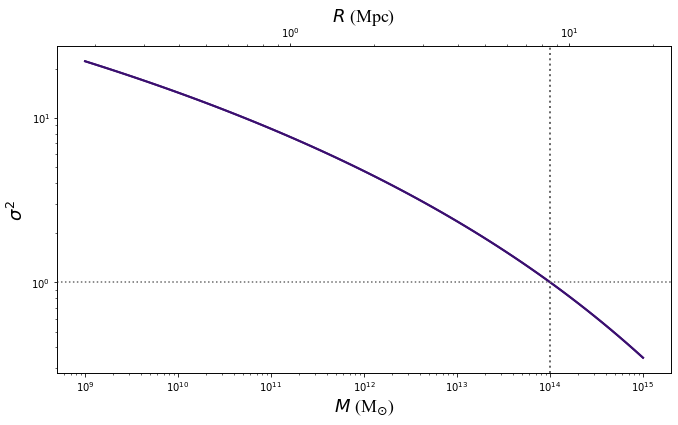

In [62]:
figsigma2, eixoM = plt.subplots(figsize = (11, 6))

# Plotando massa no eixo inferior
eixoM.plot(M_eixo, sigma2(R_func(M_eixo, 0), 0), color = cmap(0.2), linestyle = '-', label = 'z = 0', linewidth = 2)
eixoM.set_ylabel('$\sigma^{2}$', fontsize = 18, family = 'Times New Roman')
eixoM.set_xlabel('$M$ (M$_{\odot}$)', fontsize = 18, family = 'Times New Roman')
eixoM.axvline(x = 10**(14), linestyle = 'dotted', color = 'dimgray', label=f'R = {R8}', linewidth = 2)
eixoM.set_yscale('log')
eixoM.set_xscale('log')

# Criar o segundo subplot para o raio no eixo superior
eixoR = eixoM.twiny()
eixoR.plot(R_func(M_eixo, 0), sigma2(R_func(M_eixo, 0), 0), color = cmap(0.2), linestyle = '-', label = '', linewidth = 2)
eixoR.set_xlabel('$R$ (Mpc)', fontsize = 18, family = 'Times New Roman')
# eixoR.axvline(x = R8, linestyle = 'dotted', color = 'dimgray', label=f'R = {R8}', linewidth = 2)
eixoR.set_yscale('log')
eixoR.set_xscale('log')

plt.axhline(y = 1, linestyle = 'dotted', color = 'dimgray')
plt.savefig('variancia.pdf', bbox_inches = 'tight')
plt.show()

-------------------------------------------------------------

- Função de massa:

$\dfrac{\partial W}{\partial M} = \dfrac{R}{M} \left\{ \left[\dfrac{1}{k R^2} - \dfrac{3}{k^3 R^4}\right] + \cos{kR} \left[\dfrac{3}{k^2 R^3}\right] \right\}$

$\dfrac{\partial \sigma}{\partial M} = \dfrac{1}{\sigma} \left[ \dfrac{\textrm{d}k}{k} \, \Delta^2(k, t) \, W \, \dfrac{\partial W}{\partial M} \right]$

$ \dfrac{\partial \ln{\sigma^{-1}}}{\partial M} = -\dfrac{1}{\sigma} \dfrac{\partial \sigma}{\partial M}$

In [63]:
def dWdM(k, M, z):
    R_salvo = R_func(M, z)
    return (R_salvo/M)*((1/(k*R_salvo**2) - 3/((k**3)*(R_salvo**4)))*np.sin(k*R_salvo) + (3/((k**2)*(R_salvo**3)))*np.cos(k*R_salvo))

def derivsigma(M, z):
    R_salvo = R_func(M, z)
    integral, erro = quad_vec(lambda k: (1/k)*Delta2(k, z)*funcao_janela(k, R_salvo)*dWdM(k, M, z), 0, np.inf)
    return (-1/sigma2(R_salvo, z))*integral

$f(M, z) = \dfrac{2}{\pi} \dfrac{\delta_c}{\sigma} \exp{\dfrac{-\delta_c^2}{2\sigma^2}} \, \dfrac{\partial \ln{\sigma^{-1}}}{\partial M}.$

In [64]:
def fracao_de_massa(M, z):
    R_salvo = R_func(M, z)
    delta_c = delta_collapse_EdS # fit_kitayama(z)
    v = delta_c/np.sqrt(sigma2(R_salvo, z))
    return np.sqrt(2/np.pi)*v*np.exp((-v**2)/2)*derivsigma(M, z)

In [65]:
# print(np.sum(funcao_de_halos(M_eixo, 0)[:-1]*np.diff(M_eixo)))
# print(delta_c_LCDM(0), delta_c_LCDM(2), delta_c_LCDM(4), delta_c_LCDM(6))

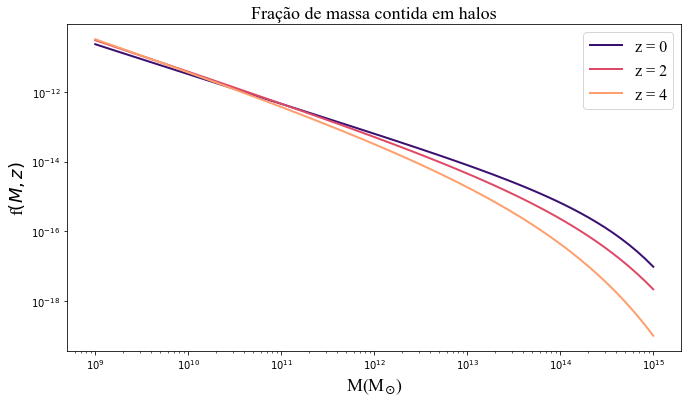

In [66]:
font_figfMz = {'family': 'Times New Roman', 'size': 16}
plt.figure(figsize=(11, 6))
plt.title('Fração de massa contida em halos', fontsize = 18, family = 'Times New Roman') 
plt.plot(M_eixo, fracao_de_massa(M_eixo, 0), color = cmap(0.2), linestyle = '-', label = 'z = 0', linewidth = 2) # 0, 1, 2
plt.plot(M_eixo, fracao_de_massa(M_eixo, 2), color = cmap(0.6), linestyle = '-', label = 'z = 2', linewidth = 2)
plt.plot(M_eixo, fracao_de_massa(M_eixo, 4), color = cmap(0.8), linestyle = '-', label = 'z = 4', linewidth = 2)
plt.ylabel('f$(M, z)$', fontsize = 18, family = 'Times New Roman')
plt.xlabel('M(M$_{\odot}$)', fontsize = 18, family = 'Times New Roman')
plt.yscale('log')
plt.xscale('log')
plt.legend(prop = font_figfMz)
plt.savefig('fracaodemassa.pdf', bbox_inches = 'tight')
plt.show()

In [67]:
def funcao_de_massa(M, z):
    return (rho_z(z)/M)*fracao_de_massa(M, z)

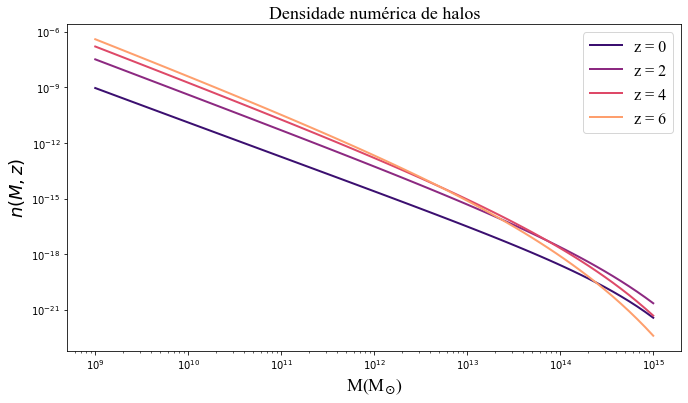

In [68]:
plt.figure(figsize=(11, 6))
plt.title('Densidade numérica de halos', fontsize = 18, family = 'Times New Roman')
plt.plot(M_eixo, funcao_de_massa(M_eixo, 0), color = cmap(0.2), linestyle = '-', label = 'z = 0', linewidth = 2)
plt.plot(M_eixo, funcao_de_massa(M_eixo, 2), color = cmap(0.4), linestyle = '-', label = 'z = 2', linewidth = 2)
plt.plot(M_eixo, funcao_de_massa(M_eixo, 4), color = cmap(0.6), linestyle = '-', label = 'z = 4', linewidth = 2)
plt.plot(M_eixo, funcao_de_massa(M_eixo, 6), color = cmap(0.8), linestyle = '-', label = 'z = 6', linewidth = 2)
plt.ylabel('$n(M, z)$', fontsize = 18, family = 'Times New Roman')
plt.xlabel('M(M$_{\odot}$)', fontsize = 18, family = 'Times New Roman')
plt.yscale('log')
plt.xscale('log')
plt.legend(prop = font_figfMz)
plt.savefig('funcaodemassa.pdf', bbox_inches = 'tight')
plt.show()